# Udacity Self Driving Car Engineer Nanodegree Project:

## Vehicle Detection

# Goal
The goal of this project is to design and implement software pipeline to detect vehicles in a video. As a result, this Jupyter notebook should be able to playback an .mp4 file of a car driving down the highway, identifying all vehicles in its view with bounding boxes.

# Introduction
## Vehicle Detection Pipeline

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
2. Train a Linear Support Vector Machine (SVM) Classifier.
3. Search for vehicles in a given .mp4 video frame using a sliding-window technique on the Linear SVM Classifier.
4. Because the sliding-window technique makes duplicate detections of vehicles (changing window sizes to identify small to large vehicles in a given video frame), create a heat map of detected vehicles, rejecting those beyond a certain threshold.
5. Draw bounding boxes around detected vehicles from the heat map and display it on the given video frame.
6. Finally, playback the video to see the detected vehicles!

# Library and Utility Function Import

In [1]:
# UTILITY FUNCTIONS IMPORT
%matplotlib inline

import numpy as np
import pickle
import cv2
import glob
import time

#skimage and sklearn imports
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#scipy import
from scipy.ndimage.measurements import label

# matplotlib imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


# python movie imports
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from utility import *

# Test of the Utility Functions for Vehicle Detection Pipeline

8792 8968
43.06 Seconds to extract HOG features
Orientations: 11
Pixels Per Cell: 16
Cells Per Block: 2
Feature Length: 1188
1.04 Seconds to train SVC
Test Accuracy of SVC =  0.9803
10 Linear SVC predictions:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
10 Test Labels:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
0.00447 Seconds to predict 10 labels with SVC


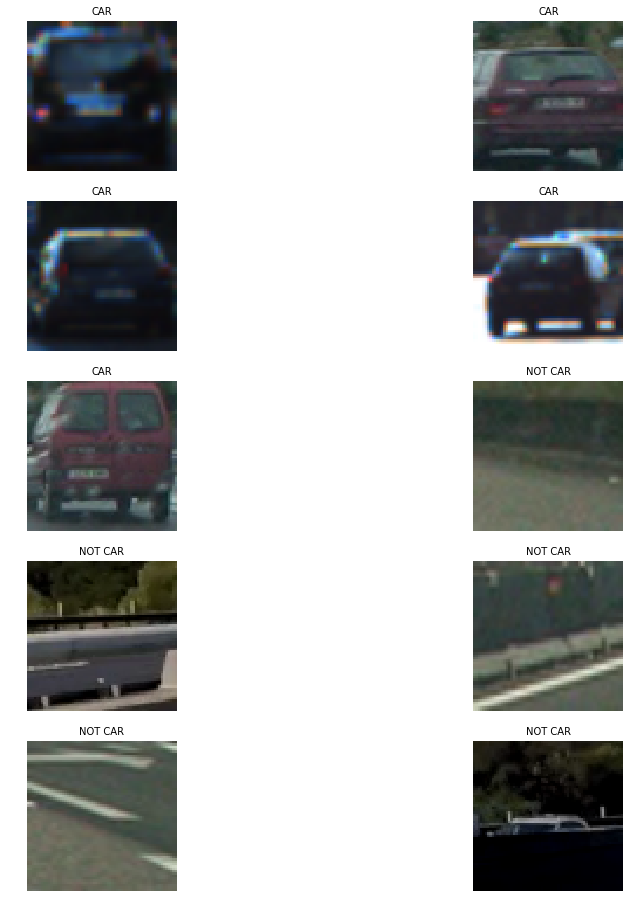

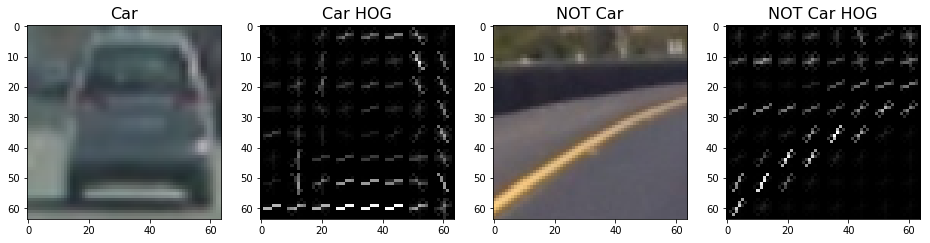

In [2]:
# TEST GLOB TO IMPORT CAR AND NOTCAR IMAGES
car_images = glob.glob('vehicles/*/*.png')
notcar_images = glob.glob('non-vehicles/*/*.png')
print(len(car_images), len(notcar_images))

# TEST MATPLOTLIB TO DISPLAY CAR AND NOT CAR IMAGES
fig, axs = plt.subplots(5,2, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(5):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('CAR', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(5,10):
    img = cv2.imread(notcar_images[np.random.randint(0,len(notcar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('NOT CAR', fontsize=10)
    axs[i].imshow(img)
    
# TEST GET HOG FEATURES
car_img = mpimg.imread(car_images[7])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(notcar_images[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)


ax, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(1, 4, figsize=(16,16))
ax.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('NOT Car', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('NOT Car HOG', fontsize=16)

# TEST TIME IT TAKES TO EXTRACT CAR AND NOTCAR FEATURES
colorspace = 'YUV' # Or RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Or 0 1, 2

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features')
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))



rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
print('Orientations:', orient)
print('Pixels Per Cell:', pix_per_cell)
print('Cells Per Block:', cell_per_block)
print('Feature Length:', len(X_train[0]))

# TEST TIME IT TAKES TO TRAIN CLASSIFIER WITH FEATURES AND LABELS
svc = LinearSVC()

t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time()
n_predict = 10
print('10 Linear SVC predictions: ', svc.predict(X_test[0:n_predict]))
print(n_predict, 'Test Labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Found 3 cars.


NotFittedError: This LinearSVC instance is not fitted yet

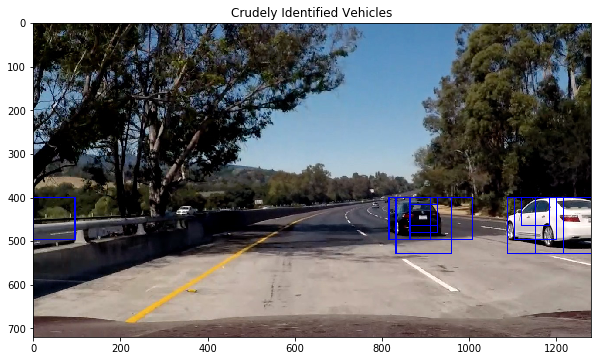

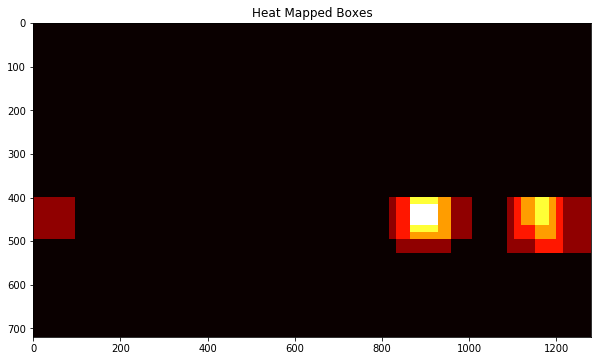

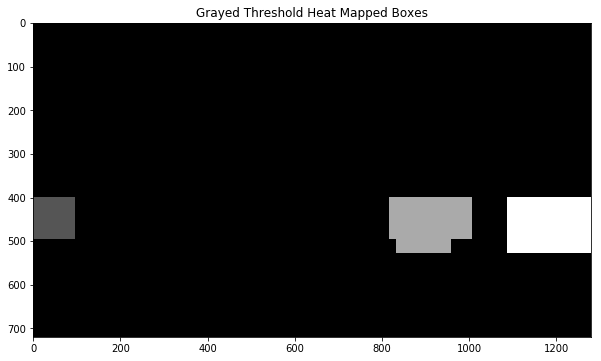

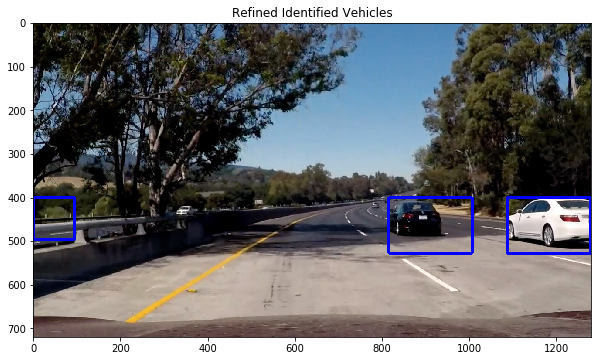

In [3]:
#TEST DRAW BOXES #
test_img = mpimg.imread('test_images/test5.jpg')
colorspace = 'YUV' # Or RGB, HSV, LUV, HLS, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Or 0, 1, 2
ystarts    = [400,416,400,432,400,432,400,464]
ystops     = [464,480,496,528,528,560,596,660]
scales     = [1.0,1.0,1.5,1.5,2.0,2.0,3.5,3.5]
rectangles = []

for i in range(len(ystarts)):
    rectangle = find_cars(test_img, ystarts[i], ystops[i], scales[i], colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None)
    rectangles.append(rectangle)

# TEST DRAWING BOXES OF VARYING SIZES AND SCALES
rectangles = [i for l in rectangles for i in l] 
test_img_rects = draw_boxes(test_img, rectangles, color=(0,0,255), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

plt.title("Crudely Identified Vehicles")
# TEST HEAT MAP #
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

# TEST HEAT MAP THRESHOLD #

labels = label(heatmap_img)
plt.title("Heat Mapped Boxes")
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print('Found', labels[1], 'cars.')

# TEST DRAW LABELED BOXES #
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
plt.title("Grayed Threshold Heat Mapped Boxes")
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.title("Refined Identified Vehicles")

# # TEST PROJECT_VIDEO.MP4 #
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

# Conclusion and Drawbacks

With the help of Udacity's Self Driving Car Nanodegree Engineer program modular instructions (emcompassed in 41 sub lessons), I was able to configure a utility.py file with functions that aid in my Vehicle Detector Pipeline. Such functionally enabled me to do the following:
1. Set up a Linear Support Vector Machine classifier
2. Extract HOG features from multiple image sets
3. Find cars by returning sets of rectangles in an image where a car might be expected
4. Draw boxes of various sizes on the respective image 
5. Remove duplicate detections using a heat map with a threshold 
6. Redraw boxes around said heat mapped images
7. Display the image with well-defined boxes around correctly detected vehicles
8. Iterate over a stream of images in a video to detect vehicles in real time!

Some drawbacks to my solution include the fact that there were some test images where a section of an image with an object was incorrectly labeled as a car. The detector mistook a green bush as an incoming car on the left side of the highway. No matter how I changed my classifier's parameters, the green bush was still identified to be a car. I'll use a different classifier (like a modified decision tree or a different support vector classifier) if I were to refine this project very soon. Until then, I had a blast figuring out how to use the sk framework to classify and detect vehicles.

# References

1. https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013
2. http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
3. http://scikit-learn.org/stable/modules/svm.html
4. http://scikit-learn.org/stable/model_selection.html#model-selection
5. http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
6. http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing